<a href="https://colab.research.google.com/github/slarkdev/AnomaliesDetection/blob/main/anomaly_detection_informer_dt1_lesly_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 119.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 116.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 121.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
import os
import datetime
import random
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, Dropout

from tensorflow.keras.layers import Input

# Fijar semilla aleatoria
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)



In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [ ]:
# 1️⃣  Instalar (solo si falla el import)
# !pip install --quiet torch torchvision torchaudio

# 2️⃣  Importar
import torch
import torch.nn as nn
import torch.optim as optim
print("PyTorch version:", torch.__version__)

# 3️⃣  Verificar GPU (opcional)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

PyTorch version: 2.6.0+cpu
Using device: cpu


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys

informer_path = '/content/drive/MyDrive/informer-lesly/Informer2020'
#if informer_path not in sys.path:
sys.path.append(informer_path)



In [ ]:
!ls /content/drive/MyDrive/informer-lesly/Informer2020/models

attn.py  decoder.py  embed.py  encoder.py  __init__.py	model.py  __pycache__


In [ ]:
import os
print(os.listdir('/content/drive/MyDrive/informer-lesly/Informer2020/models'))


['__init__.py', 'attn.py', 'decoder.py', 'embed.py', 'encoder.py', '__pycache__', 'model.py']


In [ ]:
import importlib.util
spec = importlib.util.find_spec("models.model")
print("Found!" if spec else "Not found.")


Found!


In [ ]:
#import importlib
#importlib.reload(models.model)

NameError: name 'models' is not defined

In [ ]:
from models.model import Informer

In [ ]:
def create_sequences(data, sequence_length):
 X = []
 y = []
 for i in range(len(data) - sequence_length):
    X.append(data.iloc[i:i+sequence_length][input_columns].values)
    y.append(data.iloc[i+sequence_length][output_columns].values)
 return np.array(X), np.array(y)

In [ ]:
def guardar_proyecto(core_informer, y_test, anomalías, matriz, epoch_actual, nombre_base="modelo_anomalias"):

    # 🕒 Crear carpeta con timestamp
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    carpeta = f"/content/drive/MyDrive/3w-dataset-train-test/entrenamientos-2/{nombre_base}_{timestamp}"
    os.makedirs(carpeta, exist_ok=True)

    # 1. Guardar el modelo
    checkpoint = {
        'epoch': epoch_actual,
        'model_state': core_informer.state_dict(),
        'optimizer_state': optimizer.state_dict()
    }
    torch.save(checkpoint, 'informer.pth')

    # 2. Guardar métricas
    reporte = classification_report(y_test, anomalías)
    acc = accuracy_score(y_test, anomalías)
    f1 = f1_score(y_test, anomalías)
    recall = recall_score(y_test, anomalías)
    precision = precision_score(y_test,anomalías)
    auc = roc_auc_score(y_test, anomalías)

    with open(os.path.join(carpeta, "reporte_metricas.txt"), "w") as f:
        f.write("REPORTE DE CLASIFICACIÓN\n")
        f.write(reporte)
        f.write("\n\nMétricas adicionales:\n")
        f.write(f"Accuracy: {acc:.4f}\n")
        f.write(f"Precision: {precision:.4f}\n")
        f.write(f"Recall: {recall:.4f}\n")
        f.write(f"F1-score: {f1:.4f}\n")
        f.write(f"AUC-ROC: {auc:.4f}\n")


    total_anomalias = int(np.sum(y_test))  # Cantidad total de anomalías
    anomalías_predichas = int(np.sum(anomalías.astype(int)))  # Convertir booleanos a enteros

    # Crear gráfico de barras
    plt.bar(["Real Anomalies", "Anomalies Detected"], [total_anomalias, anomalías_predichas], color=['red', 'blue'])

    # Personalizar gráfico
    plt.ylabel("Number of Anomalies")
    plt.title("Comparison of Real vs. Predicted Anomalies")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(carpeta, "grafico_comparison_real_vs_anomalies.png"))
    plt.close()

    # grafico 4 matriz de confusion
    sns.heatmap(matriz, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Normal", "Anomalous"], yticklabels=["Normal", "Anomalous"])
    plt.xlabel("Prediction")
    plt.ylabel("True Class")
    plt.title("Confusion Matrix")
    plt.savefig(os.path.join(carpeta, "grafico_confusion_matriz.png"))
    plt.close()


    print(f"✅ Todo guardado exitosamente en la carpeta: {carpeta}")


In [ ]:
class WindowDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, seq_len=96, label_len=48, pred_len=24):
        self.X = X
        self.y = y
        self.seq_len = seq_len
        self.label_len = label_len
        self.pred_len = pred_len

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x_enc = self.X[idx][:self.seq_len]
        x_dec = np.concatenate([
            self.X[idx][self.seq_len - self.label_len:self.seq_len],
            np.zeros((self.pred_len, self.X.shape[2]))
        ], axis=0)

        # marcas temporales (puedes usar timestamps reales aquí)
        x_mark_enc = np.zeros((self.seq_len, 4))       # 4 features temporales como hora, día, etc.
        x_mark_dec = np.zeros((self.label_len + self.pred_len, 4))

        return (
            torch.tensor(x_enc, dtype=torch.float32),
            torch.tensor(x_mark_enc, dtype=torch.float32),
            torch.tensor(x_dec, dtype=torch.float32),
            torch.tensor(x_mark_dec, dtype=torch.float32),
            torch.tensor(self.y[idx], dtype=torch.float32)
        )


#class WindowDataset(torch.utils.data.Dataset):
 #   def __init__(self, x, y):
  #      self.x = torch.tensor(x, dtype=torch.float32)
  #      self.y = torch.tensor(y, dtype=torch.float32)

  #  def __len__(self):
  #      return len(self.x)

  #  def __getitem__(self, idx):
  #      return self.x[idx], self.y[idx]



In [ ]:
class InformerBin(torch.nn.Module):
    def __init__(self, core):
        super().__init__()
        self.core = core

    def forward(self, x, return_latent=False):  # añade flag
        if x.dim() != 3:
            raise ValueError(f"Expected input of shape (B, L, F), but got {x.shape}")

        B, L, F = x.shape

        x_mark_enc = torch.zeros(B, L, 4, device=x.device)
        x_dec      = torch.zeros(B, 1, F, device=x.device)
        x_mark_dec = torch.zeros(B, 1, 4, device=x.device)

        out = self.core(
            x, x_mark_enc, x_dec, x_mark_dec,
            return_latent=return_latent  # ← aquí está la clave
        )

        if return_latent:
            return out[:, -1, :]  # si estás extrayendo embeddings
        else:
            return out[:, 0, 0]   # logits como antes

In [ ]:
# Especificar las rutas de los archivos en Google Drive
ruta_csv1 = "/content/drive/MyDrive/3w-dataset-train-test/dataset-interpolado-Anomalia1.csv"
ruta_csv2 = "/content/drive/MyDrive/3w-dataset-train-test/dataset-interpolado-Anomalia2.csv"
ruta_csv3 = "/content/drive/MyDrive/3w-dataset-train-test/dataset-test-06.csv"

#df0 = pd.read_csv(ruta_dataset0, parse_dates=['timestamp'], index_col='timestamp')
# Leer los CSV en DataFrames
df1 = pd.read_csv(ruta_csv1, parse_dates=['timestamp'], index_col='timestamp')
df2 = pd.read_csv(ruta_csv2, parse_dates=['timestamp'], index_col='timestamp')
df3 = pd.read_csv(ruta_csv3, parse_dates=['timestamp'], index_col='timestamp')

df1

,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,class
timestamp,,,,,,
2014-01-26 03:33:21,0.995385,0.04225,0.989734,0.015978,1.000000,0.0
2014-01-26 03:33:22,0.995385,0.04225,0.989734,0.015978,1.000000,0.0
2014-01-26 03:33:23,0.995385,0.04225,0.989734,0.015978,1.000000,0.0
2014-01-26 03:33:24,0.995385,0.04225,0.989734,0.015978,1.000000,0.0
2014-01-26 03:33:25,0.995385,0.04225,0.989734,0.015977,1.000000,0.0
...,...,...,...,...,...,...
2014-01-26 22:59:56,0.000000,1.00000,0.041357,0.000000,0.000117,1.0
2014-01-26 22:59:57,0.000000,1.00000,0.041345,0.000000,0.000085,1.0
2014-01-26 22:59:58,0.000000,1.00000,0.041333,0.000000,0.000059,1.0


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df1, test_size=0.3, shuffle=False)

In [ ]:
columns_names = df1.columns.values
columns_names

array(['P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'class'],
      dtype=object)

In [ ]:
# Definir las columnas de entrada y salida:
input_columns = ['P-TPT',	'T-TPT','P-MON-CKP', 'T-JUS-CKP','P-JUS-CKGL',]
output_columns = ['class']

In [ ]:
train = train.sort_values("timestamp")
test = test.sort_values("timestamp")

print(train['class'].value_counts())
print(test['class'].value_counts())

class
0.0    49000
Name: count, dtype: int64
class
0.0    11387
1.0     9613
Name: count, dtype: int64


In [ ]:
VentanaTiempo = 400

# Crear secuencias de entrenamiento
X_train, y_train = create_sequences(train, VentanaTiempo)
X_test, y_test = create_sequences(test, VentanaTiempo)

print(X_train.shape)
print(X_test.shape)

(48600, 400, 5)
(20600, 400, 5)


In [ ]:
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

In [ ]:
d_model = 64 # puedes variar este valor
seq_len = VentanaTiempo

# Modelo Informer
model = Informer(
    enc_in=5, #X_train.shape[2],
    dec_in=5, #X_train.shape[2],
    c_out=1, #X_train.shape[2],
    seq_len=seq_len,
    label_len=0,
    out_len=1,
    e_layers=2,
    d_layers=1,
    factor=1,
    dropout=0.1,
    d_model = d_model,
    embed='timeF',
    output_attention=False,
    distil=True,
)

if np.sum(y_train == 1) > 0:
    peso = np.sum(y_train == 0) / np.sum(y_train == 1)
    pos_weight = torch.tensor([peso], device=device)
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
else:
    criterion = torch.nn.BCEWithLogitsLoss()

optimizer  = torch.optim.Adam(model.parameters(), lr=1e-4)
device     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(5, 64, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=64, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(5, 64, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=64, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Dropout(p=

In [ ]:
import torch.nn.init as init
for m in model.projection.modules():
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

In [ ]:
for m in model.modules():
    if isinstance(m, torch.nn.Linear):
        init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.zeros_(m.bias)


In [ ]:
batch_size = 64

train_dataset = WindowDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

test_dataset = WindowDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)


In [ ]:
core_informer = InformerBin(model).to(device)


In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    core_informer.train()
    total_loss = 0

    mean_logit_epoch = []
    std_logit_epoch = []

    for x_enc, x_mark_enc, x_dec, x_mark_dec, yb in train_loader:
        xb = x_enc.to(device)
        yb = yb.to(device).float()



        # 🔧 Ajusta dimensiones
        if yb.dim() > 1:
            yb = yb.squeeze(1)  # Convierte [batch_size, 1] → [batch_size]

        optimizer.zero_grad()

        logits = core_informer(xb)

        logits = logits.view(-1)  # Asegura [batch_size]

         # 🔍 Logging de estadísticas de logits
        mean_logit_epoch.append(logits.mean().item())
        std_logit_epoch.append(logits.std().item())

        loss = criterion(logits, yb)  # Ahora sí: dimensiones iguales
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}: Loss = {total_loss/len(train_loader):.4f} | "
          f"logits.mean = {np.mean(mean_logit_epoch):.4f} | "
          f"logits.std = {np.mean(std_logit_epoch):.4f}")




Epoch 1: Loss = 0.0000 | logits.mean = -11.0155 | logits.std = 0.2324
Epoch 2: Loss = 0.0000 | logits.mean = -11.2740 | logits.std = 0.2238
Epoch 3: Loss = 0.0000 | logits.mean = -11.5617 | logits.std = 0.2175
Epoch 4: Loss = 0.0000 | logits.mean = -11.8745 | logits.std = 0.2146
Epoch 5: Loss = 0.0000 | logits.mean = -12.2125 | logits.std = 0.2189
Epoch 6: Loss = 0.0000 | logits.mean = -12.5770 | logits.std = 0.2249
Epoch 7: Loss = 0.0000 | logits.mean = -12.9637 | logits.std = 0.2326
Epoch 8: Loss = 0.0000 | logits.mean = -13.3672 | logits.std = 0.2413
Epoch 9: Loss = 0.0000 | logits.mean = -13.7812 | logits.std = 0.2538
Epoch 10: Loss = 0.0000 | logits.mean = -14.2055 | logits.std = 0.2660


In [ ]:
model.eval()
activaciones_train = []

with torch.no_grad():
    for x_enc, x_mark_enc, x_dec, x_mark_dec, yb in train_loader:
        xb = x_enc.to(device)

        #xb = xb.to(device)
        latentes = core_informer(xb, return_latent=True)
        activaciones_train.append(latentes.cpu())

activaciones_train = torch.cat(activaciones_train, dim=0)
centroide = activaciones_train.mean(dim=0)

In [ ]:
activaciones_train = []

with torch.no_grad():
    for x_enc, x_mark_enc, x_dec, x_mark_dec, _ in train_loader:
        xb = x_enc.to(device)
        latente = core_informer(xb, return_latent=True)
        activaciones_train.append(latente.cpu())  # suponiendo que ya devuelve shape (B, D)

activaciones_train = torch.cat(activaciones_train, dim=0)

In [ ]:
centroide = activaciones_train.mean(dim=0)  # shape: (D,)


In [ ]:
distancias = []

with torch.no_grad():
    for x_enc, x_mark_enc, x_dec, x_mark_dec, _ in test_loader:
        xb = x_enc.to(device)
        latente = core_informer(xb, return_latent=True)
        dist = torch.norm(latente.cpu() - centroide, dim=1)  # Euclidiana
        distancias.append(dist)

distancias = torch.cat(distancias, dim=0)  # shape: (N_test,)

In [ ]:
import numpy as np

umbral = np.percentile(distancias.numpy(), 53)  # o ajustalo según tus necesidades
y_pred = (distancias.numpy() > umbral).astype(int)

Accuracy : 0.9966504854368932
Precision: 0.9928733732699856
Recall   : 1.0
F1-score : 0.99642394402695
AUC-ROC  : 0.996859925366342
[[10918    69]
 [    0  9613]]
              precision    recall  f1-score   support

         0.0     1.0000    0.9937    0.9969     10987
         1.0     0.9929    1.0000    0.9964      9613

    accuracy                         0.9967     20600
   macro avg     0.9964    0.9969    0.9966     20600
weighted avg     0.9967    0.9967    0.9967     20600



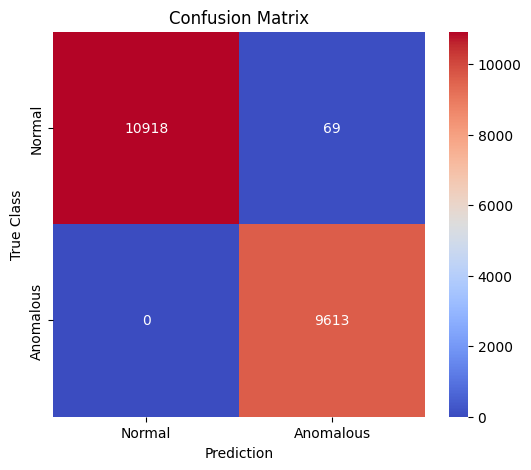

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1-score :", f1_score(y_test, y_pred, pos_label=1, average='binary'))
print("AUC-ROC  :", roc_auc_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred, digits=4))

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Normal", "Anomalous"], yticklabels=["Normal", "Anomalous"])
plt.xlabel("Prediction")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

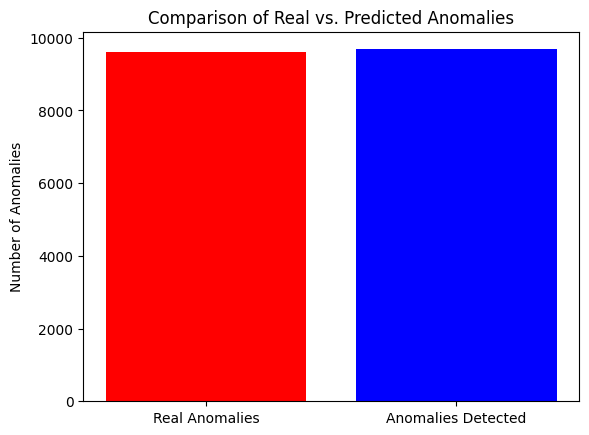

In [ ]:
total_anomalias = int(np.sum(y_test))  # Cantidad total de anomalías
anomalías_predichas = int(np.sum(y_pred.astype(int)))  # Convertir booleanos a enteros

# Crear gráfico de barras
plt.bar(["Real Anomalies", "Anomalies Detected"], [total_anomalias, anomalías_predichas], color=['red', 'blue'])

# Personalizar gráfico
plt.ylabel("Number of Anomalies")
plt.title("Comparison of Real vs. Predicted Anomalies")
plt.show()


In [ ]:
guardar_proyecto(core_informer, y_test, y_pred, cm, num_epochs, nombre_base='informer_ocl_dt1_ws_400_bs_32_e_10_acc_9933')

✅ Todo guardado exitosamente en la carpeta: /content/drive/MyDrive/3w-dataset-train-test/entrenamientos-2/informer_ocl_dt1_ws_400_bs_32_e_5_acc_9933_20250623_002740


/tmp/ipython-input-14-4109425625.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


In [ ]:
# usar esta linea solo para guardar tu ultima version de informer modificada

#rutaInformer = '/content/Informer2020'
#!mkdir -p /content/drive/MyDrive/informer-lesly/
#!cp -r /content/Informer2020 /content/drive/MyDrive/informer-lesly/